In [4]:
# SMAP(soil moisture), GPM(precipitation), GWT(ground water table) network design
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize, StandardScaler, scale
import os
import copy
import numpy as np
import pandas as pd
from utils import *
torch.manual_seed(1)

In [7]:
df=pd.read_csv('fields_1000.csv', sep=',',header=None)
k = int(df.values[0][0])
alpha = df.values[1:k+1]
logK = df.values[k+1:]
df2=pd.read_csv('heads_1000_no_pump.csv', sep=',',header=None)
heads=df2.values

features = np.transpose(alpha)
targets = np.transpose(heads)
r = 0.8
(train_X, train_y, valid_X, valid_y, X, y) = split_sample_in_order(features, targets, r)

In [10]:
Rox=int(np.sqrt(logK.shape[0]))
Roy=Rox
a = recover_mat(heads[:][1], [Rox, Roy])


64.0


In [3]:
HIDDEN_DIM = 40  # hidden dimentionality
EMBEDDING_DIM = k # embedding dimentionality
OUTPUT_DIM = heads.shape[0]
class Network(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, initial_state=True):
        super(Network, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        
        # Inputs to hidden layer linear transformation
        self.in2hidden = nn.Linear(embedding_dim, hidden_dim)
        
        #hidden to hidden
        self.hidden2hidden = nn.Linear(hidden_dim, hidden_dim)
        
        # Output layer, 1 value
        self.hidden2out = nn.Linear(hidden_dim, output_dim)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        h1 = self.in2hidden(x)
        act_h1 = self.sigmoid(h1)
        h2 = self.hidden2hidden(act_h1)
        act_h2 = self.sigmoid(h2)
        outs = self.hidden2out(act_h2)
        
        return outs


In [4]:
# initialize network, loss function and optimizer
######
model = Network(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [5]:
# train network 
######

num_epoch = 100
for epoch in range(num_epoch):  # again, normally you would NOT do 100 epochs, it is toy data
    if np.mod(epoch, 10) == 0:
        print("# epoch: ", epoch)
    
    for x_i, y_i in zip(train_X, train_y):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Run our forward pass.
        scores = model(x_i.view(1,-1))
        #
        # Step 3. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(scores, y_i.view(1, -1))
        loss.backward()
        optimizer.step()

# epoch:  0
# epoch:  10
# epoch:  20
# epoch:  30
# epoch:  40
# epoch:  50
# epoch:  60
# epoch:  70
# epoch:  80
# epoch:  90


In [6]:
inputs = valid_X.view(-1, 1, EMBEDDING_DIM)
outs = model(inputs)
# print(outs)

tensor(0.5557, grad_fn=<MeanBackward1>)


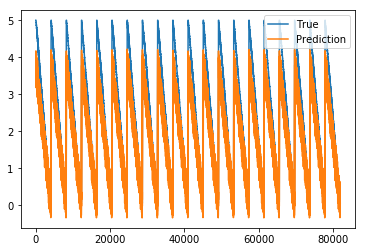

In [7]:
legd = ["True", "Prediction"]
s_target =np.std(targets)
m_target = np.mean(targets)
#resolved_out = (outs * s_target) + m_target
#resolved_y = (valid_y * s_target) + m_target
#visulize_tensor_series(resolved_y, resolved_out, legd=legd, saveFig=False, figName='nn_40_500.png')
#err = resolved_y - resolved_outerr = resolved_y - resolved_out
visulize_tensor_series(valid_y, outs, legd=legd, saveFig=False, figName='filled_nn.png')
err = valid_y - outs

mse = (err ** 2).mean()
print(mse)
#print(err)

In [8]:
'''
class LSTM_value_predict(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, initial_state = True):
        super(LSTM_value_predict, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        
        # The LSTM takes sample embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)
        
        # Apply RelU net to filter out negative values 
        self.relu = nn.ReLU()
        
        # The linear layer that maps from hidden state space to predicted value
        self.hidden2val = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        outs = self.hidden2val(lstm_out1)
        #scores = self.relu(outs)
        scores = outs
        return scores
'''

'\nclass LSTM_value_predict(nn.Module):\n    def __init__(self, embedding_dim, hidden_dim, initial_state = True):\n        super(LSTM_value_predict, self).__init__()\n        self.hidden_dim = hidden_dim\n        self.embedding_dim = embedding_dim\n        \n        # The LSTM takes sample embeddings as inputs, and outputs hidden states\n        # with dimensionality hidden_dim.\n        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim)\n        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)\n        \n        # Apply RelU net to filter out negative values \n        self.relu = nn.ReLU()\n        \n        # The linear layer that maps from hidden state space to predicted value\n        self.hidden2val = nn.Linear(hidden_dim, 1)\n        \n    def forward(self, x):\n        lstm_out1, _ = self.lstm1(x)\n        lstm_out2, _ = self.lstm2(lstm_out1)\n        outs = self.hidden2val(lstm_out1)\n        #scores = self.relu(outs)\n        scores = outs\n        return scores\n'